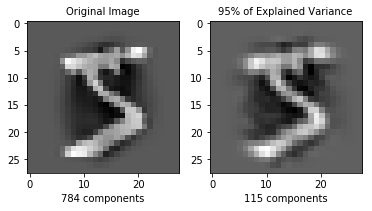

In [3]:
import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.decomposition import PCA

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.95)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('95% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

In [4]:
final_error_rate =[]

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time 
start_time = time.time()



tdata = np.genfromtxt("mnist_test.txt", delimiter=',')
test_exp1 = tdata[:,0]

cl_type1=OneVsOneClassifier(LogisticRegression(solver='saga',max_iter = 10000)).fit(reduced_data,label)



res1=cl_type1.predict(reduced_test_data)

acc_type1=accuracy_score(test_exp1,res1)
err_type1=1-acc_type1
final_error_rate.append(err_type1)
mat_c1 =confusion_matrix(test_exp1,res1)

print(mat_c1)

print("Accuracy:",acc_type1)
print("Error Rate:",err_type1)
print("Time: %s seconds" %(time.time()-start_time))



[[ 956    0    0    1    0    6    9    1    3    4]
 [   0 1122    5    2    0    1    2    1    2    0]
 [   7    1  985    9    5    2    2    3   17    1]
 [   0    1    6  974    0   12    0    6    8    3]
 [   1    3    3    1  946    2    5    1    3   17]
 [   3    0    0   10    2  863    4    0    8    2]
 [   8    4    5    1    7    6  923    0    3    1]
 [   1    1   12    1    4    0    0  993    1   15]
 [   6    1    6   10    5    8    1    3  927    7]
 [   2    3    2    8   22    4    1   16    2  949]]
Accuracy: 0.9638
Error Rate: 0.03620000000000001
Time: 2735.4989767074585 seconds


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time 
start_time = time.time()


tdata = np.genfromtxt("mnist_test.txt", delimiter=',')
test_exp2 = tdata[:,0]

cl_type2=LogisticRegression(penalty='l1',multi_class='ovr').fit(reduced_data,label)



res2=cl_type2.predict(reduced_test_data)

acc_type2=accuracy_score(test_exp2,res2)
err_type2=1-acc_type2
final_error_rate.append(err_type2)



mat_c2 =confusion_matrix(test_exp2,res2)

print(mat_c2)

print("accuracy:",acc_type2)
print("error rate:",err_type2)
print("time: %s seconds" %(time.time()-start_time))


C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 960    0    0    2    1    6    7    1    1    2]
 [   0 1122    2    1    0    1    4    0    4    1]
 [   7    1  970    7    5    1    5    7   29    0]
 [   1    1   10  961    1   14    0    7   12    3]
 [   2    1    4    2  935    2    4    3    8   21]
 [   5    0    1    6    6  845   10    1   14    4]
 [   9    2    5    1    8   13  916    0    3    1]
 [   2    2   15    0    7    0    0  972    6   24]
 [   9    1   10    8    7   13    3    2  913    8]
 [  11    4    3   14   29    4    0   18    7  919]]
accuracy: 0.9513
error rate: 0.048699999999999966
time: 169.5782494544983 seconds


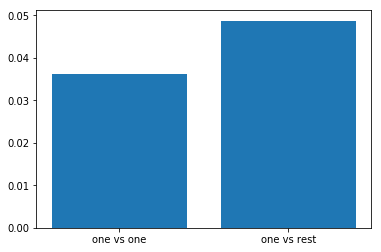

In [6]:
import matplotlib.pyplot as plt
#import matplotlib.pyplot.hist
x=np.arange(2)
plt.bar(x,height=final_error_rate)
plt.xticks(x,['one vs one','one vs rest'])
plt.show()

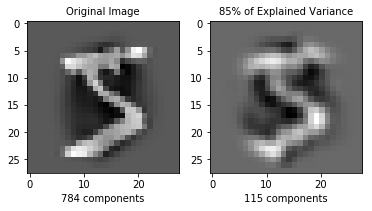

In [7]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.85)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('85% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

In [8]:
final_error_rate2 =[]

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time 
start_time = time.time()



tdata = np.genfromtxt("mnist_test.txt", delimiter=',')
test_exp3 = tdata[:,0]

cl_type3=OneVsOneClassifier(LogisticRegression()).fit(reduced_data,label)



res3=cl_type3.predict(reduced_test_data)

acc_type3=accuracy_score(test_exp3,res1)
err_type3=1-acc_type1
final_error_rate2.append(err_type3)
mat_c3 =confusion_matrix(test_exp3,res3)

print(mat_c3)

print("Accuracy:",acc_type3)
print("Error Rate:",err_type3)
print("Time: %s seconds" %(time.time()-start_time))



C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[[ 957    0    2    1    0    6    8    1    3    2]
 [   0 1118    4    2    0    2    3    0    6    0]
 [   6    0  985   11    3    1    3    6   17    0]
 [   1    1    4  974    1   12    0    5    9    3]
 [   2    0    3    2  947    0    6    1    5   16]
 [   4    0    0   12    3  856    8    1    6    2]
 [   6    3    4    1    5   10  926    1    1    1]
 [   1    2   13    0    1    0    0  994    2   15]
 [   4    0    7   10    4   12    4    2  926    5]
 [   0    4    1    7   18    5    1   19    4  950]]
Accuracy: 0.9638
Error Rate: 0.03620000000000001
Time: 604.2053864002228 seconds


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time 
start_time = time.time()


tdata = np.genfromtxt("mnist_test.txt", delimiter=',')
test_exp4 = tdata[:,0]

cl_type4=LogisticRegression(penalty='l1',multi_class='ovr').fit(reduced_data,label)



res4=cl_type4.predict(reduced_test_data)

acc_type4=accuracy_score(test_exp4,res4)
err_type4=1-acc_type4
final_error_rate2.append(err_type4)



mat_c4 =confusion_matrix(test_exp4,res4)

print(mat_c4)

print("accuracy:",acc_type4)
print("error rate:",err_type4)
print("time: %s seconds" %(time.time()-start_time))

C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 960    1    1    0    0    5    6    2    3    2]
 [   0 1114    2    2    0    1    4    1   11    0]
 [   5    3  950   13    9    3    4    6   38    1]
 [   1    1    8  962    1   13    0    6   12    6]
 [   1    0    8    2  930    2    7    3    8   21]
 [  13    2    1    8    8  835    8    2   11    4]
 [   8    3    8    2    8   16  909    0    3    1]
 [   2    4   15    1    3    1    0  978    3   21]
 [   4    1   10    8    5   15    7    4  909   11]
 [  10    5    2   13   31    2    1   23    9  913]]
accuracy: 0.946
error rate: 0.05400000000000005
time: 39.46908760070801 seconds


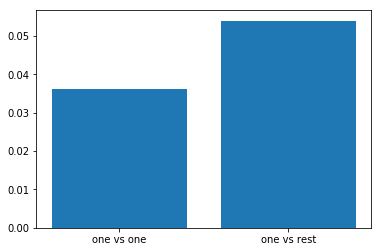

In [10]:
import matplotlib.pyplot as plt
#import matplotlib.pyplot.hist
x=np.arange(2)
plt.bar(x,height=final_error_rate2)
plt.xticks(x,['one vs one','one vs rest'])
plt.show()

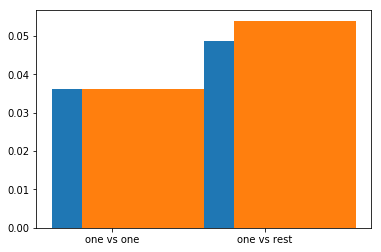

In [11]:
import matplotlib.pyplot as plt
#import matplotlib.pyplot.hist
x=np.arange(2)
plt.bar(x,height=final_error_rate)
plt.bar(x+0.2,height=final_error_rate2)
plt.xticks(x,['one vs one','one vs rest'])
plt.show()